In [3]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import cv2
import os

import datetime

%matplotlib inline

In [33]:
def loaddata(fname,resize=None,grayscale=True):
    img = cv2.imread(fname)
    if resize is not None:
        img = cv2.resize(img,resize,cv2.INTER_LANCZOS4)
    if grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.asarray(img,dtype=np.float32)/255

def openCAM(cam_idx=0,window_name='DiffuseCam'):
    """
    Opens camera window and returns last frame in RGB
    """
    
    cv2.namedWindow(window_name)
    vc = cv2.VideoCapture(cam_idx)

    if vc.isOpened(): # try to get the first frame
        rval, frame = vc.read()
    else:
        rval = False
    while rval:
        cv2.imshow(window_name, frame)
        rval, frame = vc.read()
        key = cv2.waitKey(20)
        if key == 27: # exit on ESC
            break
    cv2.destroyWindow(window_name)
    
    #BGR to RGB
    frame = [frame[:,:,2],frame[:,:,1],frame[:,:,0]]
    return np.asarray(np.swapaxes(np.swapaxes(frame,0,2),0,1),dtype=np.float32)/255

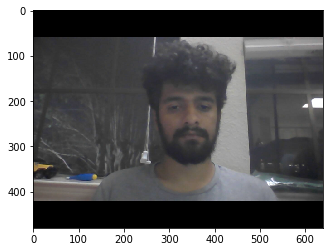

In [35]:
frame = openCAM()
plt.imshow(frame)

In [29]:
datetime.datetime.now()


2019-11-16 17:25:12.140629
